### Import

In [2]:
import os
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import spectral.io.aviris as aviris
import colour
import matplotlib.tri as mtri
import cv2 as cv
from PIL import Image
from scipy.signal import resample_poly
from scipy.stats import multivariate_normal as mnorm
from scipy import ndimage
from matplotlib import cm
from mpl_toolkits import mplot3d
from skimage import io, color
from scipy.spatial.distance import cdist
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Rectangle, Circle, Wedge, Polygon

### Fonts

In [3]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Boundary Helper Function

In [4]:
def boundary(LAB,RGB):
    
    idx1 = np.where(RGB[:,0] >= 1.0)[0]
    idx2 = np.where(RGB[:,1] >= 1.0)[0]
    idx3 = np.where(RGB[:,2] >= 1.0)[0]
    RGB[idx1,0] = 0.5
    RGB[idx1,1] = 0.5
    RGB[idx1,2] = 0.5
    RGB[idx2,0] = 0.5
    RGB[idx2,1] = 0.5
    RGB[idx2,2] = 0.5
    RGB[idx3,0] = 0.5
    RGB[idx3,1] = 0.5
    RGB[idx3,2] = 0.5
    LAB[idx1,0] = -1
    LAB[idx1,1] = -1
    LAB[idx1,2] = -1
    LAB[idx2,0] = -1
    LAB[idx2,1] = -1
    LAB[idx2,2] = -1
    LAB[idx3,0] = -1
    LAB[idx3,1] = -1
    LAB[idx3,2] = -1
    

    idx1 = np.where(RGB[:,0] == 0.0)[0]
    idx2 = np.where(RGB[:,1] == 0.0)[0]
    idx3 = np.where(RGB[:,2] == 0.0)[0]
    RGB[idx1,0] = 0.5
    RGB[idx1,1] = 0.5
    RGB[idx1,2] = 0.5
    RGB[idx2,0] = 0.5
    RGB[idx2,1] = 0.5
    RGB[idx2,2] = 0.5
    RGB[idx3,0] = 0.5
    RGB[idx3,1] = 0.5
    RGB[idx3,2] = 0.5
    LAB[idx1,0] = -1
    LAB[idx1,1] = -1
    LAB[idx1,2] = -1
    LAB[idx2,0] = -1
    LAB[idx2,1] = -1
    LAB[idx2,2] = -1
    LAB[idx3,0] = -1
    LAB[idx3,1] = -1
    LAB[idx3,2] = -1

    #Return
    return LAB,RGB

### Create Color wheel from A-B Perspective

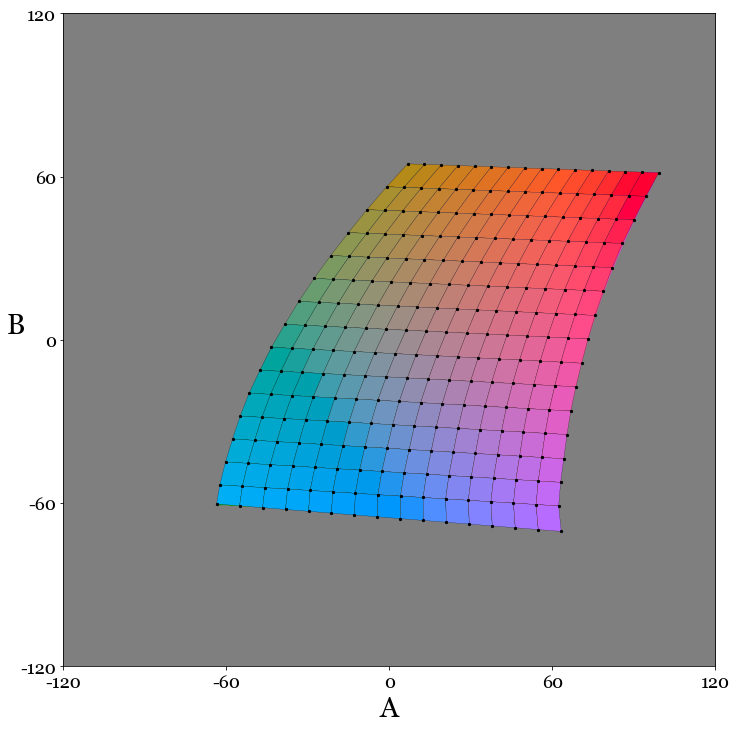

In [5]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1)
resolution = 1024
a = np.linspace(-120,120,resolution,True)
b = np.linspace(-120,120,resolution,True)
A,B = np.meshgrid(a,b)
L = np.zeros((A.shape)) + 60
D = np.sqrt(A**2 + B**2)
LAB = np.array([L.ravel(),A.ravel(),B.ravel()]).T
RGB = color.lab2rgb(LAB);

#Remove any color that is strictly 0 or 1 on any channel. 
#These form the boundary of the colors we can generate by converting LAB to RGB
LAB,RGB = boundary(LAB,RGB)
RGB = np.reshape(RGB,(resolution,resolution,3));
LAB = np.reshape(LAB,(resolution,resolution,3));
BIN = LAB.copy()[:,:,0]

#Threshold and find the corners of the space so we can build the lattice
BIN[BIN>-1] = 255
BIN[BIN<0] = 0
BIN = np.abs(np.diff(BIN))
xv,yv = np.where(BIN > 0)
E = np.vstack((xv,yv))
leftE = E[:,::2].T
rightE = E[:,1::2].T
leftE = leftE[:-40,:].astype(float)
rightE = rightE[10:,:].astype(float)
rightE = resample_poly(rightE,100,104,axis=0)
rightE = rightE[3:-10,:]
leftE = leftE[::6,:]
rightE = rightE[::6,:]
leftE = leftE[::3,:]
rightE = rightE[::3,:]
leftE = leftE[::2,:]
rightE = rightE[::2,:]
leftE[:,0] = leftE[:,0] - 10
rightE[:,0] = rightE[:,0] - 10
leftE = np.vstack((leftE,leftE[-1,:]))
rightE = np.vstack((rightE,rightE[-1,:]))
leftE[-1,0] = leftE[-1,0] + 30
leftE[-1,1] = leftE[-1,1] - 5
rightE[0,0] = rightE[0,0] + 0
rightE[:,1] = rightE[:,1] + 4
rightE[0,1] = rightE[0,1] + 2
rightE[1,1] = rightE[1,1] + 2
rightE[2,1] = rightE[2,1] + 2
# rightE[3,1] = rightE[3,1] + 4
# rightE[4,1] = rightE[4,1] + 4
# rightE[5,1] = rightE[5,1] + 2
rightE[-1,0] = rightE[-1,0] + 40
rightE[-1,1] = rightE[-1,1] + 4
rightE = np.round(rightE)
gridres = rightE.shape[0]

gridvalx = []
gridvaly = []
for i in range(rightE.shape[0]):
    xval = np.linspace(leftE[i,0],rightE[i,0],gridres).tolist()
    yval = np.linspace(leftE[i,1],rightE[i,1],gridres).tolist()
    gridvalx = gridvalx + xval
    gridvaly = gridvaly + yval
gridvalx = np.array(gridvalx)
gridvaly = np.array(gridvaly)

#Create Grid
G = np.vstack((gridvalx,gridvaly)).T
G = G - 512
G = G / 512 * -120
Gnew = G.copy()
Gnew[:,0] = -G[:,1]
Gnew[:,1] = G[:,0]

colors = []
patches = []
plt.imshow(RGB,extent=(-120,120,-120,120))
GX = np.reshape(Gnew[:,0],(16,16))
GY = np.reshape(Gnew[:,1],(16,16))
for i in range(GX.shape[0]-1):
    for j in range(GY.shape[0]-1):
        x0 = GX[i,j]
        x1 = GX[i+1,j]
        x2 = GX[i+1,j+1]
        x3 = GX[i,j+1]
        y0 = GY[i,j]
        y1 = GY[i+1,j]
        y2 = GY[i+1,j+1]
        y3 = GY[i,j+1]
        xp = np.vstack((x0,x1,x2,x3))
        yp = np.vstack((y0,y1,y2,y3))
        points = np.hstack((xp,yp))
        lab = np.zeros((1,3))
        lab[0,0] = 60
        lab[0,1:] = np.mean(points,axis=0)
        rgb = color.lab2rgb(lab)
        polygon = Polygon(points, True)
        patches.append(polygon)
        colors.append(rgb[0,:])
colors = np.array(colors)
p = PatchCollection(patches, alpha=1.0,linewidth=0.2,facecolors=colors,edgecolors='k')
ax.add_collection(p)
plt.scatter(Gnew[:,0],Gnew[:,1],c='k',s=5)
plt.xlabel('A',fontsize=28,**csfont);
plt.ylabel('B',fontsize=28,**csfont,rotation=0);
plt.yticks(np.linspace(-120,120,5),labels=np.linspace(-120,120,5).astype(int),fontsize=18,**csfont);
plt.xticks(np.linspace(-120,120,5),labels=np.linspace(-120,120,5).astype(int),fontsize=18,**csfont);
plt.savefig('../../assets/matplotlib/019_LABcat.png',dpi=300,bbox_inches="tight");

### Check is it is a valid RGB

To stay within the boundary of the gamut of CIELAB, we reject RGB values for which one of the channel (R,G,B) is either perfectly 0 or perfectly 1. Most likely, the represent RGB values that we generated from LAB for each there is no RGB value within the bounds of \[0..1\]. The mapping algorithm used in this notebook provided by the color module will then round impossible RGB values (with one of the channels >1.0 or <0.0 to 1.0 and 0.0 respectively. While we can render these rounded RGB values can be rendered, they are misleading, in reality they are LAB values for which there is no corresponding RGB value, and thus fall outside the gamut.

In [6]:
def check_valid_rgb(rgb):
    
    idx = []
    idx0 = np.where(rgb >= 1.0)[0].tolist()
    idx1 = np.where(rgb <= 0.0)[0].tolist()
    idx = idx0 + idx1
    return len(idx) == 0

### Draw the Manifold

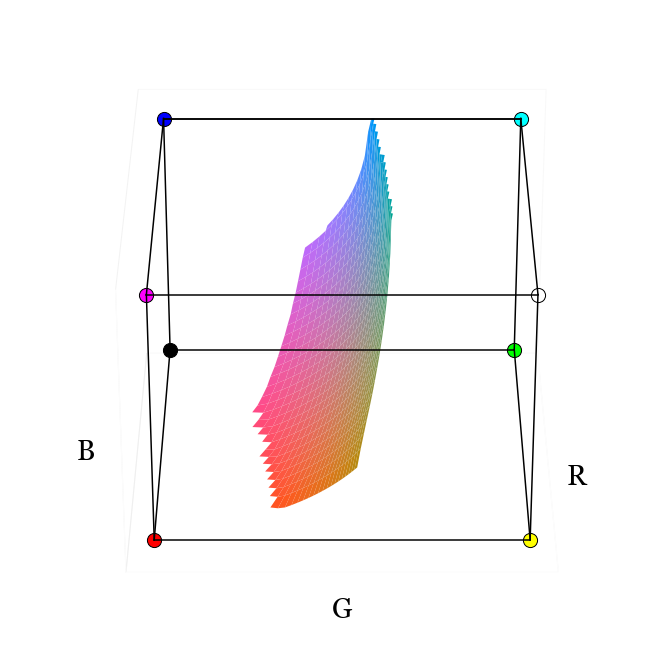

In [82]:
#Init
resolution = 1024
plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

a = np.linspace(-120,120,resolution,True)
b = np.linspace(-120,120,resolution,True)
A,B = np.meshgrid(a,b)
L = np.zeros((A.shape)) + 60
D = np.sqrt(A**2 + B**2)
LAB = np.array([L.ravel(),A.ravel(),B.ravel()]).T
RGB = color.lab2rgb(LAB);

#Remove any color that is strictly 0 or 1 on any channel. 
#These form the boundary of the colors we can generate by converting LAB to RGB
LAB,RGB = boundary(LAB,RGB)
RGB = np.reshape(RGB,(resolution,resolution,3));
LAB = np.reshape(LAB,(resolution,resolution,3));
BIN = LAB.copy()[:,:,0]

#Threshold and find the corners of the space so we can build the lattice
BIN[BIN>-1] = 255
BIN[BIN<0] = 0
BIN = np.abs(np.diff(BIN))
xv,yv = np.where(BIN > 0)
E = np.vstack((xv,yv))
leftE = E[:,::2].T
rightE = E[:,1::2].T
leftE = leftE[:-40,:].astype(float)
rightE = rightE[10:,:].astype(float)
rightE = resample_poly(rightE,100,104,axis=0)
leftE = leftE[::6,:]
rightE = rightE[::6,:]
leftE = leftE[::3,:]
rightE = rightE[::3,:]
rightE[0,1] = rightE[0,1] + 20
rightE = np.round(rightE)
gridres = rightE.shape[0]
gridvalx = []
gridvaly = []
for i in range(rightE.shape[0]):
    xval = np.linspace(leftE[i,0],rightE[i,0],gridres).tolist()
    yval = np.linspace(leftE[i,1],rightE[i,1],gridres).tolist()
    gridvalx = gridvalx + xval
    gridvaly = gridvaly + yval
gridvalx = np.array(gridvalx)
gridvaly = np.array(gridvaly)

#Create Grid
G = np.vstack((gridvalx,gridvaly)).T
G = G - 512
G = G / 512 * -120
Gnew = G.copy()
Gnew[:,0] = -G[:,1]
Gnew[:,1] = G[:,0]

#Create Polygons
colors = []
patches = []
GX = np.reshape(Gnew[:,0],(30,30))
GY = np.reshape(Gnew[:,1],(30,30))
for i in range(GX.shape[0]-1):
    for j in range(GY.shape[0]-1):
        x0 = GX[i,j]
        x1 = GX[i+1,j]
        x2 = GX[i+1,j+1]
        x3 = GX[i,j+1]
        y0 = GY[i,j]
        y1 = GY[i+1,j]
        y2 = GY[i+1,j+1]
        y3 = GY[i,j+1]
        xp = np.vstack((x0,x1,x2,x3))
        yp = np.vstack((y0,y1,y2,y3))
        points = np.hstack((xp,yp))
        lab = np.zeros((points.shape[0],3))
        lab[:,0] = 60
        lab[:,1] = points[:,0]
        lab[:,2] = points[:,1]
        rgb = np.zeros((1,lab.shape[0],lab.shape[1]))
        rgb[0,:,:] = color.lab2rgb(lab)
        meanrgb = np.mean(rgb,axis=0)
        meanrgb = np.mean(meanrgb,axis=0)
        if (check_valid_rgb(meanrgb)):
            poly = Poly3DCollection(rgb, facecolors = rgb[0,:,:],alpha=1.0)
            ax.add_collection3d(poly)

#Set Drawing Elements
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_yticks(np.linspace(0,1,5),labels=np.linspace(0,1,5),fontsize=14,**csfont);
ax.set_xticks(np.linspace(0,1,5),labels=np.linspace(0,1,5),fontsize=14,**csfont);
ax.set_zticks(np.linspace(0,1,5),labels=np.linspace(0,1,5),fontsize=14,**csfont);
ax.set_xlabel('R',fontsize=28,**csfont);
ax.set_ylabel('G',fontsize=28,**csfont);
ax.set_zlabel('B',fontsize=28,**csfont);
ax.grid(visible=False)
ax.axes.xaxis.set_ticks([],c='w')
ax.axes.yaxis.set_ticks([])
ax.axes.zaxis.set_ticks([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.w_xaxis.line.set_color((1,1,1))
ax.w_yaxis.line.set_color((1,1,1))
ax.w_zaxis.line.set_color((1,1,1))


#RGB cube points and lines
ax.plot3D([0,0],[0,0],[0,1],c='k',zorder=1000);
ax.plot3D([0,0],[0,1],[0,0],c='k',zorder=1000);
ax.plot3D([0,1],[0,0],[0,0],c='k',zorder=1000);
ax.plot3D([1,0],[1,1],[1,1],c='k',zorder=1000);
ax.plot3D([1,1],[1,1],[1,0],c='k',zorder=1000);
ax.plot3D([0,0],[1,1],[0,1],c='k',zorder=1000);
ax.plot3D([0,0],[0,1],[1,1],c='k',zorder=1000);
ax.plot3D([0,0],[0,1],[1,1],c='k',zorder=1000);
ax.plot3D([1,1],[1,0],[1,1],c='k',zorder=1000);
ax.plot3D([1,0],[0,0],[1,1],c='k',zorder=1000);
ax.plot3D([1,1],[0,1],[0,0],c='k',zorder=1000);
ax.plot3D([1,1],[0,0],[0,1],c='k',zorder=1000);
ax.plot3D([0,1],[1,1],[0,0],c='k',zorder=1000);
for i in range(2):
    for j in range(2):
        for k in range(2):
            ax.scatter(i,j,k,color=(i,j,k),alpha=1.0,edgecolor='k',s=200,zorder=3000)

#Save Some Static Images
ax.view_init(elev=20., azim=300)   
plt.savefig('../../assets/matplotlib/019_color_manifold_static_1.png',dpi=300,bbox_inches="tight")
ax.view_init(elev=20., azim=240)   
plt.savefig('../../assets/matplotlib/019_color_manifold_static_2.png',dpi=300,bbox_inches="tight")
ax.view_init(elev=20., azim=120)   
plt.savefig('../../assets/matplotlib/019_color_manifold_static_3.png',dpi=300,bbox_inches="tight")
ax.view_init(elev=20., azim=60)   
plt.savefig('../../assets/matplotlib/019_color_manifold_static_4.png',dpi=300,bbox_inches="tight")

#Render Images for animated GIF
azimuths = np.linspace(0,720,720)
elevations = 30 + (np.sin(np.linspace(0,720,720) / 180 * np.pi * 4) * 10)
for i in range(len(elevations)):
    ax.view_init(elev=elevations[i], azim=azimuths[i])
    plt.savefig('../../assets/gifs/manifolds_color/' + str(i) + '.png',dpi=200,bbox_inches="tight")